# SCGEN:  Perturbation Prediction

In [1]:
import sys
#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scgen[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/theislab/scgen@$branch#egg=scgen[tutorials]

In [2]:
import logging
import scanpy as sc
import scgen

In [3]:
import torch
print("torch:", torch.__version__)
import scgen
print("scgen:", scgen.__version__)
import numpy
print("numpy:", numpy.__version__)

torch: 2.9.0+cu128
scgen: 2.1.1
numpy: 2.3.4


### Loading Train Data

In [4]:
#!pip install cell-gears
#!pip install torch_geometric
from gears import PertData
pert_data = PertData("data/")
pert_data.load(data_name="norman")
adata = pert_data.adata 

Found local copy...
Found local copy...
Found local copy...
These perturbations are not in the GO graph and their perturbation can thus not be predicted
['RHOXF2BB+ctrl' 'LYL1+IER5L' 'ctrl+IER5L' 'KIAA1804+ctrl' 'IER5L+ctrl'
 'RHOXF2BB+ZBTB25' 'RHOXF2BB+SET']
Local copy of pyg dataset is detected. Loading...
Done!


In [5]:
adata.obs["condition"]
adata.obs["condition_name"]
#adata.obs["control"]
#adata

cell_barcode
AAACCTGAGGCATGTG-1     A549_TSC22D1+ctrl_1+1
AAACCTGAGGCCCTTG-1      A549_KLF1+MAP2K6_1+1
AAACCTGCACGAAGCA-1               A549_ctrl_1
AAACCTGCAGACGTAG-1    A549_CEBPE+RUNX1T1_1+1
AAACCTGCAGCCTTGG-1       A549_MAML2+ctrl_1+1
                               ...          
TTTGTCAGTCAGAATA-8               A549_ctrl_1
TTTGTCATCAGTACGT-8       A549_FOXA3+ctrl_1+1
TTTGTCATCCACTCCA-8       A549_CELF2+ctrl_1+1
TTTGTCATCCCAACGG-8      A549_BCORL1+ctrl_1+1
TTTGTCATCTGGCGAC-8      A549_MAP4K3+ctrl_1+1
Name: condition_name, Length: 89357, dtype: category
Categories (277, object): ['A549_AHR+FEV_1+1', 'A549_AHR+KLF1_1+1', 'A549_AHR+ctrl_1+1', 'A549_ARID1A+ctrl_1+1', ..., 'A549_ctrl+UBASH3B_1+1', 'A549_ctrl+ZBTB1_1+1', 'A549_ctrl+ZBTB25_1+1', 'A549_ctrl_1']

In [6]:
stimulated = "SAMD1+ZBTB1"
control = "ctrl"
cell_type = "A549"

In [7]:
# control이랑 선택한 perturbation만 남기기
train_new = adata[adata.obs["condition"].isin([control, stimulated])]
train_new.obs["condition"]

cell_barcode
AAACCTGCACGAAGCA-1    ctrl
AAACCTGGTATAATGG-1    ctrl
AAACCTGTCCGATATG-1    ctrl
AAACGGGCAATGGACG-1    ctrl
AAAGATGAGATGAGAG-1    ctrl
                      ... 
TTTGCGCAGGCAGGTT-8    ctrl
TTTGGTTGTTAAGATG-8    ctrl
TTTGGTTTCCTGCCAT-8    ctrl
TTTGTCAGTAGCGTGA-8    ctrl
TTTGTCAGTCAGAATA-8    ctrl
Name: condition, Length: 7517, dtype: category
Categories (2, object): ['ctrl', 'SAMD1+ZBTB1']

### Preprocessing Data

In [8]:
train_new = train_new.copy()

In [9]:
scgen.SCGEN.setup_anndata(train_new, batch_key="condition", labels_key="cell_type")

## Creating and Saving the model¶

In [10]:
model = scgen.SCGEN(train_new)
model.save("../saved_models/model_perturbation_prediction.pt", overwrite=True)

## Training the Model

In [11]:
model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA A30 MIG 2g.12gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-d8c14bb1-941e-4adf-09f8-3cddd1e34633/1/0;]


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 25 records. Best score: 672.911. Signaling Trainer to stop.


### Latent Space

In [12]:
latent_X = model.get_latent_representation()
latent_adata = sc.AnnData(X=latent_X, obs=train_new.obs.copy())

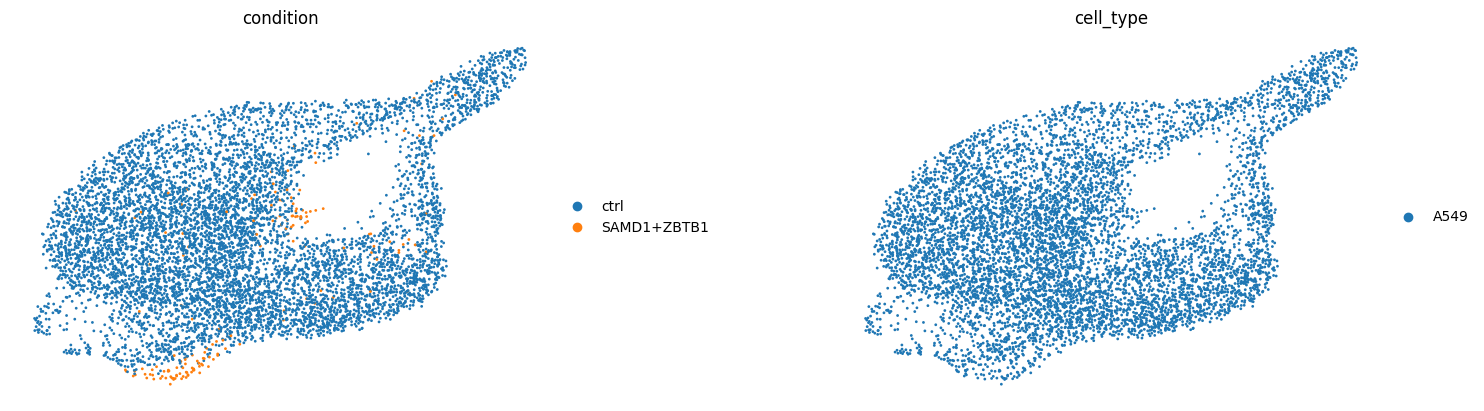

In [13]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)
sc.pl.umap(latent_adata, color=['condition', 'cell_type'], wspace=0.4, frameon=False,
           save='latentspace_batch32_klw000005_z100__100e.pdf')

## Prediction

After training the model you can pass the adata of the cells you want to perturb. Here we pass unperturbed CD4T cells


Here the 'adata' contains the cells that you want estimate the perturbation based on them. we set "ctrl" to our control labels and "stim" to our stimulated labels. If you apply it in another context just set "ctrl" :"your_control_label" and "stim":"your_stimulated_label". the returned value is a numpy matrix of our predicted cells and the second one is the difference vector between our conditions which might become useful later.

In [14]:
pred, delta = model.predict(
    ctrl_key=control,
    stim_key=stimulated,
    celltype_to_predict=cell_type
)
pred.obs['condition'] = 'pred'

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In the previous block, the difference between conditions is by default computed using all cells (obs_key="all"). However, some times you might have a rough idea that which groups (e.g. cell types) are close to your cell type of interest. This might give you more accurate predictions. For example, we can restrict the delta computation only to CD8T and NK cells. We provide dictionary in form of obs_key={"cell_type": ["CD8T", "NK"]} which is telling the model to look at "cell_type" labels in adata (here: train_new) and only compute the delta vector based on "CD8T" and "NK" cells :

pred, delta = scg.predict(adata=train_new, adata_to_predict=unperturbed_cd4t, conditions={"ctrl": "control", "stim": "stimulated"}, cell_type_key="cell_type", condition_key="condition", obs_key={"cell_type": ["CD8T", "NK"]})`

## Evaluation of the predcition¶


#### Extracting both control and real stimulated CD4T cells from our dataset

In [15]:
ctrl_adata = adata[((adata.obs['cell_type'] == cell_type) & (adata.obs['condition'] == control))]
stim_adata = adata[((adata.obs['cell_type'] == cell_type) & (adata.obs['condition'] == stimulated))]
#ctrl_adata = train_new[((train_new.obs['cell_type'] == cell_type) & (train_new.obs['condition'] == control))]
#stim_adata = train_new[((train_new.obs['cell_type'] == cell_type) & (train_new.obs['condition'] == stimulated))]

In [16]:
ctrl_adata

View of AnnData object with n_obs × n_vars = 7353 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'

In [17]:
stim_adata

View of AnnData object with n_obs × n_vars = 164 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'

Merging predicted cells with real ones

In [18]:
eval_adata = ctrl_adata.concatenate(stim_adata, pred)

### Embedding all real and predicted cells in one PCA plot¶

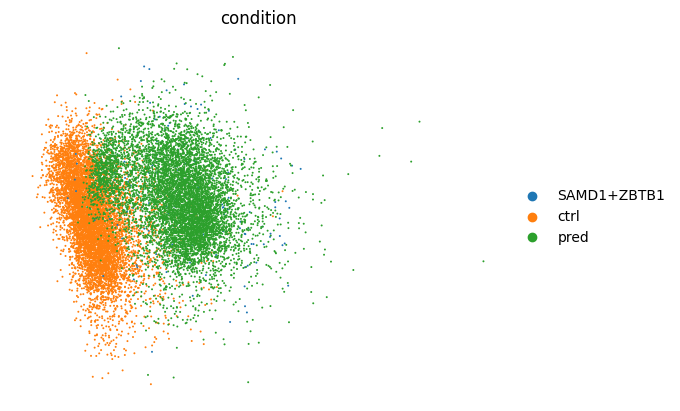

In [19]:
sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color="condition", frameon=False,
           save='pred_stim_b32_klw000005_z100__100e.pdf')

## Mean correlation plot¶

You can also visualize your mean gene expression of your predicted cells vs control cells while highlighting your genes of interest (here top 10 differentially expressed genes)

In [20]:
pred_cell = adata[adata.obs["cell_type"] == cell_type]

In [ ]:
sc.tl.rank_genes_groups(pred_cell, groupby="condition", method="wilcoxon")
diff_genes = pred_cell.uns["rank_genes_groups"]["names"][stimulated]
print(diff_genes)

In [ ]:
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={"x": "pred", "y": stimulated},
    gene_list=diff_genes[:10],
    labels={"x": "predicted", "y": "ground truth"},
    path_to_save="./reg_mean1.pdf",
    show=True,
    legend=False
)

You can also pass a list of differentially epxressed genes to compute correlation based on them

In [ ]:
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={"x": "pred", "y": stimulated},
    gene_list=diff_genes[:10],
    top_100_genes= diff_genes,
    labels={"x": "predicted","y": "ground truth"},
    path_to_save="./reg_mean1.pdf",
    show=True,
    legend=False
)

### Violin plot for a specific gene¶


Let's go deeper and compare the distribution of "ISG15", the top DEG between stimulated and control CD4T cells between predcited and real cells

In [ ]:
#sc.pl.violin(eval_adata, keys="ISG15", groupby="condition")